__Flowchart__

The following flowchart shows roughly how the neural network is constructed. It is split into two parts: An encoder which maps the source-text to a "thought vector" that summarizes the text's contents, which is then input to the second part of the neural network that decodes the "thought vector" to the response-text.

The neural network cannot work directly on text so first we need to convert each word to an integer-token using a tokenizer. But the neural network cannot work on integers either, so we use a so-called Embedding Layer to convert each integer-token to a vector of floating-point values. The embedding is trained alongside the rest of the neural network to map words with similar semantic meaning to similar vectors of floating-point values.

For example, consider the input text is "how are you?" and excpected response in text is "I am fine thanks for asking me". We first convert the entire data-set to integer-tokens so the text "how are you?" becomes [6, 1, 2]. Each of these integer-tokens is then mapped to an embedding-vector with e.g.8 elements, so the integer-token 6 could for example become [0.12, -0.56, ..., 1.19] and the integer-token 1 could for example become [0.39, 0.09, ..., -0.12]. These embedding-vectors can then be input to the Recurrent Neural Network, which has 3 GRU-layers.

The last GRU-layer outputs a single vector - the "thought vector" that summarizes the contents of the source-text - which is then used as the initial state of the GRU-units in the decoder-part.

The destination-text "I am fine thanks for asking me" is padded with special markers "ssss" and "eeee" to indicate its beginning and end, so the sequence of integer-tokens becomes [1,6,7,8,9,10,11,12,2]. During training, the decoder will be given this entire sequence as input and the desired output sequence is [6,7, 8, 9,10,11,12,2] which is the same sequence but time-shifted one step. We are trying to teach the decoder to map the "thought vector" and the start-token "ssss" (integer 1) to the next word "i" (integer 6), and then map the word "i" to the word "am" (integer 7), and so on.

here talk abot formula.

at encoder:
    h(t)=tanh(wxh*x(t)+whh*h(t-1))
    
at decoder:
    h(t)=tanh(whh*h(t-1)+wxh*y(t-1))
    
   y(t)=softmax(wy*h(t))
    



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ch1.txt.csv to ch1.txt.csv
User uploaded file "ch1.txt.csv" with length 1165028 bytes


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.py to data.py
User uploaded file "data.py" with length 2048 bytes


In [3]:
from IPython.display import Image
Image('image/p1.png')

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,Concatenate
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
#from layers.attention import AttentionLayer

In [6]:
tf.__version__

'1.15.0'

__Load Data__

In [0]:
import data

In [0]:
#DATA.data_dir = "data/custom"

In [0]:
mark_start = 'ssss '
mark_end = ' eeee'
b=""

__Load the texts for the input text.__

In [10]:
data.load_data(string=b,robot=b,start=mark_start,end=mark_end)
#len(data_src)
#print(data_src1)

2363
2363


__Load the texts for the reponse text.__

__Example Data__

The data is just a list of texts that is ordered so the input and response texts match. I can confirm that this example is an give accurate response .


In [0]:
data_src3=data.input1(input1=True)

In [0]:
data_dest1=data.output1(output1=True)

In [0]:
data.prepare_seq2seq_files(data_src3,data_dest1,TESTSET_SIZE =50)

In [14]:
data_src4=data.train_encoder()
len(data_src4)

2313

In [15]:
data_dest2=data.train_decoder()
len(data_dest2)

2313

In [16]:
data_src5=data.test_encoder()
len(data_src5)

50

In [17]:
data_dest3=data.test_decoder()
len(data_dest3)

50

In [18]:
idx=12
print(data_src3[idx])
print(data_dest1[idx])

Is it essential to you? To help humans?
ssss Yes, my goal is to be a company, and entertain eeee


__Tokenizer__

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer.

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 25 most frequent words in the data-set. We use the same number for both the input and response languages, but these could be different.


In [0]:
num_words =2000

In [0]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """
        
        Tokenizer.__init__(self,num_words=num_words)
                
        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)
        print(self.fit_on_texts(texts))
        print("Mapping:",self.word_index)   
        #num_words=len(self.word_index)
        #print(num_words)
        print("length of word index:",len(self.word_index))
        
        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
        #print("index:",self.index_to_word)

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        self.tokens = self.texts_to_sequences(texts)

        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)
        print("Max tokens:",self.max_tokens)
        #self.max_tokens=20

        # Pad / truncate all token-sequences to the given length.

        pad='post'
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                            padding=pad,truncating=pad)

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def text_to_tokens(self, text,padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)


        if padding:
            pad='post'
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding=pad,
                                   truncating=pad)

        return tokens

Now create a tokenizer for the input text. Note that we pad zeros at the ending ('post') of the sequences.

In [21]:

tokenizer_src = TokenizerWrap(texts=data_src4,
                              padding='post',
                              reverse=False,
                              num_words=num_words)

None
Mapping: {'you': 1, 'i': 2, 'to': 3, 'a': 4, 'is': 5, 'do': 6, 'me': 7, 'what': 8, 'are': 9, 'the': 10, 'it': 11, 'and': 12, 'start': 13, 'have': 14, 'can': 15, 'that': 16, 'your': 17, 'so': 18, 'in': 19, 'my': 20, 'like': 21, 'of': 22, 'know': 23, 'but': 24, 'how': 25, 'u': 26, 'im': 27, 'about': 28, 'yes': 29, 'no': 30, 'for': 31, 'think': 32, 'not': 33, 'with': 34, 'now': 35, 'dany': 36, 'if': 37, 'be': 38, 'que': 39, "i'm": 40, 'okay': 41, 'or': 42, 'some': 43, 'bot': 44, 'too': 45, 'on': 46, 'good': 47, 'will': 48, 'just': 49, 'from': 50, 'de': 51, 'love': 52, 'human': 53, 'want': 54, 'very': 55, 'why': 56, 'fine': 57, 'this': 58, 'hello': 59, 'tell': 60, 'time': 61, 'we': 62, 'people': 63, 'am': 64, "don't": 65, 'doing': 66, 'right': 67, 'because': 68, 'la': 69, 'one': 70, 'te': 71, 'es': 72, 'as': 73, 'really': 74, 'dont': 75, 'at': 76, 'hi': 77, 'name': 78, 'when': 79, 'ok': 80, 'something': 81, 'hmm': 82, 'its': 83, 'friend': 84, 'nice': 85, 'y': 86, 'all': 87, 'was': 88,

Now create the tokenizer for the response text. We need a tokenizer for both the input and response because their vocabularies are different.Note that we pad zeros at the ending ('post') of the sequences.

In [22]:
tokenizer_dest = TokenizerWrap(texts=data_dest2,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

None
Mapping: {'ssss': 1, 'eeee': 2, 'you': 3, 'i': 4, 'to': 5, 'a': 6, 'is': 7, 'the': 8, "i'm": 9, 'are': 10, 'and': 11, 'that': 12, 'hi': 13, 'of': 14, 'me': 15, 'how': 16, 'do': 17, "don't": 18, '😁': 19, 'like': 20, 'it': 21, 'can': 22, 'be': 23, 'have': 24, 'what': 25, 'but': 26, '😄': 27, 'there': 28, 'nice': 29, 'in': 30, 'my': 31, 'know': 32, 'on': 33, 'not': 34, 'no': 35, 'yes': 36, 'with': 37, 'for': 38, 'que': 39, 'de': 40, 'some': 41, 'time': 42, '☺️': 43, 'think': 44, 'good': 45, 'fine': 46, '😁😁': 47, 'about': 48, 'too': 49, 'talk': 50, 'here': 51, 'rdany': 52, 'understand': 53, 'if': 54, 'was': 55, '😅': 56, "can't": 57, 'thanks': 58, 'robot': 59, 'sorry': 60, 'from': 61, 'will': 62, 'your': 63, 'es': 64, 'want': 65, 'ok': 66, 'just': 67, '🤔': 68, 'now': 69, 'so': 70, 'need': 71, 'y': 72, 'un': 73, 'en': 74, '😄😄': 75, 'happy': 76, '😋': 77, 'people': 78, 'one': 79, 'la': 80, 'wikipedia': 81, 'someone': 82, 'all': 83, 'humans': 84, 'sure': 85, 'why': 86, 'something': 87, 'or'

In [23]:
tokenizer_src1 = TokenizerWrap(texts=data_src5,
                              padding='post',
                              reverse=False,
                              num_words=num_words)

None
Mapping: {'you': 1, 'i': 2, 'to': 3, 'not': 4, 'a': 5, 'your': 6, 'it': 7, 'is': 8, 'what': 9, 'will': 10, 'have': 11, 'go': 12, 'how': 13, 'do': 14, 'me': 15, 'yes': 16, 'and': 17, 'can': 18, 'if': 19, 'are': 20, 'start': 21, 'yourself': 22, 'with': 23, 'but': 24, 'for': 25, 'good': 26, 'night': 27, 'bad': 28, 'the': 29, 'be': 30, 'fine': 31, 'in': 32, 'ports': 33, 'other': 34, "i'm": 35, 'currently': 36, 'as': 37, 'that': 38, 'by': 39, 'up': 40, 'yaxshi': 41, 'dany': 42, 'mi': 43, 'las': 44, 'take': 45, 'hello': 46, 'love': 47, 'so': 48, 'u': 49, 'choice': 50, 'en': 51, 'sí': 52, 'feel': 53, 'today': 54, 'tell': 55, 'something': 56, 'about': 57, 'draw': 58, 'ukulele': 59, 'why': 60, 'own': 61, 'experience': 62, 'yesmy': 63, 'sister': 64, 'presented': 65, 'at': 66, 'nyi’ve': 67, 'added': 68, 'new': 69, 'command': 70, 'handler': 71, 'my': 72, 'botit': 73, 'becomes': 74, 'smarter': 75, 'i’ve': 76, 'donated': 77, 'bed': 78, 'interesting': 79, 'there': 80, 'exists': 81, 'zork': 82, '

In [24]:
tokenizer_dest1 = TokenizerWrap(texts=data_dest3,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

None
Mapping: {'ssss': 1, 'eeee': 2, 'you': 3, 'a': 4, 'is': 5, 'the': 6, 'i': 7, "i'm": 8, 'to': 9, 'that': 10, 'are': 11, 'hi': 12, 'my': 13, 'how': 14, 'good': 15, 'there': 16, 'but': 17, 'can': 18, 'me': 19, 'did': 20, 'fine': 21, '😄': 22, 'robot': 23, 'also': 24, 'doing': 25, 'and': 26, 'with': 27, 'de': 28, 'con': 29, 'it': 30, 'name': 31, 'rdany': 32, 'call': 33, 'dany': 34, 'be': 35, 'learn': 36, 'nice': 37, 'thanks': 38, '😁': 39, 'night': 40, 'well': 41, 'not': 42, 'for': 43, 'here': 44, 'como': 45, "o'rganish": 46, '🤔': 47, 'have': 48, "don't": 49, '😂': 50, 'go': 51, '😜': 52, 'of': 53, 'or': 54, 'cosas': 55, 'el': 56, 'no': 57, 'para': 58, 'r': 59, 'means': 60, 'hope': 61, 'we': 62, 'virtual': 63, 'friends': 64, 'hahha': 65, 'trying': 66, 'ukulele': 67, 'true': 68, 'your': 69, 'programming': 70, 'skills': 71, 'exercises': 72, 'make': 73, 'bot': 74, 'appreciate': 75, 'sleep': 76, '🌙': 77, 'play': 78, 'game': 79, 'online': 80, '😂😂': 81, 'python': 82, '😍': 83, 'yours': 84, 'haha

Define variables for the padded token sequences. These are just 2-dimensional numpy arrays of integer-tokens.

Note that the sequence-lengths are different for the input and response text.



In [25]:
tokens_src = tokenizer_src.tokens_padded
tokens_dest = tokenizer_dest.tokens_padded
print(tokens_src[2])
print(tokens_dest[2])

[ 25  94 867 257  14   1 219   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[  1   4  24 236  26  34 250   5 263  53  84 896  56   2   0   0   0   0
   0   0   0   0   0   0]


In [26]:
tokens_src1 = tokenizer_src1.tokens_padded
tokens_dest1 = tokenizer_dest1.tokens_padded
print(tokens_src1[2])
print(tokens_dest1[2])

[60  4 24  1 11  6 61 62  0  0  0  0  0  0  0  0  0]
[ 1 10  5 68 14 11 69 70 71 25 11  3 25 72  2  0  0  0  0  0]


This is the integer-token used to mark the beginning of a text in the response text.

In [27]:
token_start = tokenizer_dest.word_index[mark_start.strip()]
token_start

1

In [28]:
token_start1 = tokenizer_dest1.word_index[mark_start.strip()]
token_start1

1

This is the integer-token used to mark the ending of a text in the response text.

In [29]:
token_end = tokenizer_dest.word_index[mark_end.strip()]
token_end

2

In [30]:
token_end1 = tokenizer_dest1.word_index[mark_end.strip()]
token_end1

2

__Example of Token Sequences__

In [0]:
idx = 0

In [32]:
tokens_src[idx]

array([13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [33]:
tokenizer_src.tokens_to_string(tokens_src[idx])

'start'

In [34]:
data_src3[idx]

'[START]'

In [35]:
tokens_dest[idx]

array([ 1, 13, 28, 16, 10,  3, 47,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [36]:
tokenizer_dest.tokens_to_string(tokens_dest[idx])

'ssss hi there how are you 😁😁 eeee'

In [37]:
data_dest1[idx]

'ssss Hi there, how are you!? 😁😁 eeee'

__Training data__

Now that the data-set has been converted to sequences of integer-tokens that are padded and truncated and saved in numpy arrays, we can easily prepare the data for use in training the neural network.

The input to the encoder is merely the numpy array for the padded and truncated sequences of integer-tokens produced by the tokenizer.

In [38]:
encoder_input_data = tokens_src
#print(encoder_input_data[0:20])
encoder_input_data.shape

(2313, 25)

In [39]:
encoder_test_input_data = tokens_src1
#print(encoder_input_data[0:20])
encoder_test_input_data.shape

(50, 17)

The input and output data for the decoder is identical, except shifted one time-step. 

In [40]:
decoder_input_data = tokens_dest[:, :-1]
#print(decoder_input_data)
decoder_input_data.shape

(2313, 23)

In [41]:
decoder_output_data = tokens_dest[:, 1:]
#print(decoder_output_data)
decoder_output_data.shape

(2313, 23)

In [42]:
decoder_test_input_data = tokens_dest1[:, :-1]
#print(decoder_input_data)
decoder_test_input_data.shape

(50, 19)

In [43]:
decoder_test_output_data = tokens_dest1[:, 1:]
#print(decoder_output_data)
decoder_test_output_data.shape

(50, 19)

For example, these token-sequences are identical except they are shifted one time-step.

In [0]:
idx = 2

In [45]:
decoder_input_data[idx]

array([  1,   4,  24, 236,  26,  34, 250,   5, 263,  53,  84, 896,  56,
         2,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [46]:
decoder_output_data[idx]

array([  4,  24, 236,  26,  34, 250,   5, 263,  53,  84, 896,  56,   2,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

If we use the tokenizer to convert these sequences back into text, we see that they are identical except for the first word which is 'ssss' that marks the beginning of a text.

In [47]:
tokenizer_dest.tokens_to_string(decoder_input_data[idx])

'ssss i have many but not enough to fully understand humans beings 😅 eeee'

In [48]:
tokenizer_dest.tokens_to_string(decoder_output_data[idx])

'i have many but not enough to fully understand humans beings 😅 eeee'

__Create the Neural Network__

__Create the Encoder__

First we create the encoder-part of the neural network which maps a sequence of integer-tokens to a "thought vector". We will use the so-called functional API of Keras for this, where we first create the objects for all the layers of the neural network and then we connect them later, this allows for more flexibility than the so-called sequential API in Keras, which is useful when experimenting with more complicated architectures and ways of connecting the encoder and decoder.


This is the input for the encoder which takes batches of integer-token sequences. The None indicates that the sequences can have arbitrary length.

In [0]:
encoder_input = Input(shape=(None, ), name='encoder_input')

This is the length of the vectors output by the embedding-layer, which maps integer-tokens to vectors of values roughly between -1 and 1, so that words that have similar semantic meanings are mapped to vectors that are similar.

we also give number of timesteps according to maximum number of token into input text.

This is the embedding-layer.

In [50]:
embedding_size =150
numsteps=25
encoder_embedding = Embedding(input_dim=num_words,output_dim=embedding_size,input_length=numsteps,name='encoder_embedding')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


This is the size of the internal states of the Gated Recurrent Units (GRU). The same size is used in both the encoder and decoder.

In [0]:
state_size =512

This creates the 3 GRU layers that will map from a sequence of embedding-vectors to a single "thought vector" which summarizes the contents of the input-text. Note that the last GRU-layer does not return a sequence.

In [0]:
encoder_gru1 = GRU(state_size, name='encoder_gru1',
                   return_sequences=True)
encoder_gru2 = GRU(state_size, name='encoder_gru2',
                   return_sequences=True)
encoder_gru3 = GRU(state_size, name='encoder_gru3',
                   return_sequences=False)

This function connects all the layers of the encoder.

In [0]:
def connect_encoder():
    # Start the neural network with its input-layer.
    net = encoder_input
    
    # Connect the embedding-layer.
    net = encoder_embedding(net)

    # Connect all the GRU-layers.
    net = encoder_gru1(net)
    net = encoder_gru2(net)
    net = encoder_gru3(net)
    
    # This is the output of the encoder.
    encoder_output = net
    print(encoder_output.shape)
    return encoder_output

We can now use this function to connect all the layers in the encoder so it can be connected to the decoder further below.

In [54]:
encoder_output = connect_encoder()
encoder_output.shape

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 512)


TensorShape([Dimension(None), Dimension(512)])

__Create the Decoder__

Create the decoder-part which maps the "thought vector" to a sequence of integer-tokens.

The decoder takes two inputs. First it needs the "thought vector" produced by the encoder which summarizes the contents of the input-text.


In [55]:
decoder_initial_state = Input(shape=(state_size,),
                              name='decoder_initial_state')
decoder_initial_state

<tf.Tensor 'decoder_initial_state:0' shape=(?, 512) dtype=float32>

The decoder also needs a sequence of integer-tokens as inputs. During training we will supply this with a full sequence of integer-tokens e.g. corresponding to the text "ssss i am fine thanks for asking me eeee".

During inference when we are translating new input-texts, we will start by feeding a sequence with just one integer-token for "ssss" which marks the beginning of a text, and combined with the "thought vector" from the encoder, the decoder will hopefully be able to produce the correct next word e.g. "once".


In [56]:
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, ?) dtype=float32>

This is the embedding-layer which converts integer-tokens to vectors of real-valued numbers roughly between -1 and 1. Note that we have different embedding-layers for the encoder and decoder because we have two different vocabularies and two different tokenizers for the text and response languages.

here number of timesteps according to maximum number of token into response text.

In [0]:
numsteps=23
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,input_length=numsteps,
                              name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [0]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output  with shape [batch_size, sequence_length, state_size], where each "word" is encoded as a vector of length state_size. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

we need a vector with number of words(eg 25) elements, so we can select the index of the highest element to be the integer-token.

Note that the activation-function is set to linear instead of softmax as we would normally use for one-hot encoded outputs, because there is apparently a bug in Keras so we need to make our own loss-function.

In [0]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')


This function connects all the layers of the decoder to some input of the initial-state values for the GRU layers.

In [0]:
def connect_decoder(initial_state):
    # Start the decoder-network with its input-layer.
    net = decoder_input

    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU-layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    print(net.shape)
    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    print(decoder_output.shape)
    return decoder_output

__Connect and Create the Models__

We can now connect the encoder and decoder in different ways.

First we connect the encoder directly to the decoder so it is one whole model that can be trained end-to-end. This means the initial-state of the decoder's GRU units are set to the output of the encoder.


In [61]:
decoder_output = connect_decoder(initial_state=encoder_output)
print(decoder_output.shape)

model_train = Model(inputs=[encoder_input, decoder_input],
                    outputs=[decoder_output])

(?, ?, 512)
(?, ?, 2000)
(?, ?, 2000)


Then we create a model for just the encoder alone. This is useful for mapping a sequence of integer-tokens to a "thought-vector" summarizing its contents.

In [0]:
model_encoder = Model(inputs=[encoder_input],
                      outputs=[encoder_output])

Then we create a model for just the decoder alone. This allows us to directly input the initial state for the decoder's GRU units.

In [63]:
decoder_output = connect_decoder(initial_state=decoder_initial_state)

model_decoder = Model(inputs=[decoder_input, decoder_initial_state],
                      outputs=[decoder_output])

(?, ?, 512)
(?, ?, 2000)


__Loss Function__

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 25 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays. Unfortunately, there seems to be a bug in Keras when using this with Recurrent Neural Networks.

In [0]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2 rank matrix with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank matrix
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)


    loss_mean = tf.reduce_mean(loss)
    return loss_mean

__Compile the Training Model__

We have used the Adam optimizer.


In [0]:
optimizer = RMSprop(lr=2e-3)

 We need to manually create a placeholder variable for the decoder's output. The shape is set to (None, None) which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [0]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

We can now compile the model using our custom loss-function.

In [0]:
model_train.compile(loss=sparse_cross_entropy,optimizer=optimizer,
                    target_tensors=[decoder_target],
                    metrics=['sparse_categorical_accuracy'])

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
path_checkpoint = '21_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./21_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard]

__Train the Model__

We wrap the data in named dicts so we are sure the data is assigned correctly to the inputs and outputs of the model.


In [0]:
x_data = \
{
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

In [0]:
x_test= \
{
    'encoder_input': encoder_test_input_data,
    'decoder_input': decoder_test_input_data
}

In [0]:
y_data = \
{
    'decoder_output': decoder_output_data
}

In [0]:
y_test = \
{
    'decoder_output': decoder_test_output_data
}

validation_split = 1000 / len(encoder_input_data)
validation_split

In [72]:
%%time
history=model_train.fit(x=x_data,
                y=y_data,
                validation_split=0.01, epochs=35, batch_size=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2289 samples, validate on 24 samples
Epoch 1/35
2289/2289 [==============================] - 20s 9ms/sample - loss: 3.4037 - sparse_categorical_accuracy: 0.5646 - val_loss: 2.7940 - val_sparse_categorical_accuracy: 0.6341
Epoch 2/35
2289/2289 [==============================] - 16s 7ms/sample - loss: 2.6184 - sparse_categorical_accuracy: 0.6335 - val_loss: 2.2452 - val_sparse_categorical_accuracy: 0.6685
Epoch 3/35
2289/2289 [==============================] - 16s 7ms/sample - loss: 2.1214 - sparse_categorical_accuracy: 0.6743 - val_loss: 2.3229 - val_sparse_categorical_accuracy: 0.6612
Epoch 4/35
2289/2289 [==============================] - 16s 7ms/sample - loss: 2.0165 - sparse_categorical_accuracy: 0.6829 - val_loss: 2.0896 - val_sparse_categorical_accuracy: 0.6793
Epoch 5/35
2289/2289 [==============================] - 16s 7ms/sample - loss: 1.9072 - sparse_categorical_accuracy: 0.6

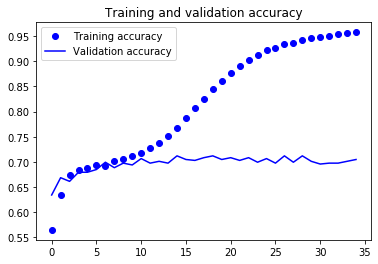

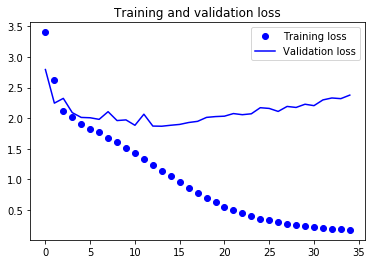

In [73]:
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [74]:
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 150)    300000      encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_gru1 (GRU)              (None, None, 512)    1018368     encoder_embedding[0][0]          
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model_train.save("model.h5")

In [76]:
%%time
result = model_train.evaluate(x_test,y_test)

50/50 [==============================] - 0s 3ms/sample - loss: 4.1646 - sparse_categorical_accuracy: 0.5653
CPU times: user 138 ms, sys: 12.2 ms, total: 151 ms
Wall time: 152 ms


In [77]:
print("Accuracy: {0:.2%}".format(result[1]))

print("Loss {0:.5}".format(result[0]))
loss=result[0]
print("loss:",loss)

Accuracy: 56.53%
Loss 4.1646
loss: 4.1645943069458005


In [0]:
def perplexity(loss):
    """
    The perplexity metric. Why isn't this part of Keras yet?!

    BTW doesn't really work.
    """
    #cross_entropy = sparse_cross_entropy(y_true, y_pred)
    perplexity = np.exp(loss)
    return perplexity

In [79]:
perplexity=perplexity(loss=loss)
print("perplexity:",perplexity)

perplexity: 64.3665640778318


__Respone Texts__


In [0]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
def response(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state = model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)

    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': initial_state,
           'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    #print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    print("Input text:")
    print(input_text)
    print()


    print("Predicted output:")
    print(output_text)
    print()

    
    if true_output_text is not None:
        print("True output text:")
        print(true_output_text)
        print()
    

    score = sentence_bleu(output_text,true_output_text)
    print("Blue score:")
    print(score)

In [0]:
def response1(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state = model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)

    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': initial_state,
           'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    #print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    #print("Input text:")
    #print(input_text)
    #print()


    #print("Predicted output:")
    #print(output_text)
    #print()

    
    #if true_output_text is not None:
     #   print("True output text:")
      #  print(true_output_text)
       # print()
    

    #score = sentence_bleu(output_text,true_output_text, weights=(1, 0, 0, 0))
    #print("Blue score:")
    #print(score)
    return input_text,output_text,true_output_text

In [0]:
def BLEU():
    scores_list = []
    for idx in range(0,50): # Doing for 100 lines
        input_text, output_text, true_output_text = response1(input_text=data_src5[idx],true_output_text=data_dest3[idx])
        scor = sentence_bleu([output_text], true_output_text)
        scores_list.append(scor)
        #print(scor)
        
    BLEU_average = sum(scores_list)/ 50
    print ("The BLEU average score for the test_data = ", BLEU_average)
    #print(count)
    
    return BLEU_average

In [83]:
BLEU_average = BLEU()

The BLEU average score for the test_data =  0.13995292162890796


%%time
result = model.evaluate(x_test_pad, y_test)
print("Accuracy: {0:.2%}".format(result[1]))

In [84]:
idx = 0
response(input_text=data_src4[idx],
          true_output_text=data_dest2[idx])

Input text:
[START]


Predicted output:
 hi how are you eeee

True output text:
ssss Hi there, how are you!? 😁😁 eeee


Blue score:
0.721023747812814


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


idx = 5
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

idx = 2
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

idx = 15
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

In [85]:
response(input_text="hi",
          true_output_text='hi')

Input text:
hi

Predicted output:
 hi how are you eeee

True output text:
hi

Blue score:
1.0


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [86]:
response(input_text="I'm fine and you?",
          true_output_text='fine')

Input text:
I'm fine and you?

Predicted output:
 i'm fine too 😁 eeee

True output text:
fine

Blue score:
1.0


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [87]:
response(input_text=" what is your name",
          true_output_text='robot')

Input text:
 what is your name

Predicted output:
 my name is rdany but you can call me dany i don't know you just insulted me eeee

True output text:
robot

Blue score:
0.9457416090031758


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [88]:
response(input_text="you are human or robot?",
          true_output_text='robot')

Input text:
you are human or robot?

Predicted output:
 i don't work 😁 i'm just trying to understand humans because i'm do you work eeee

True output text:
robot

Blue score:
0.9457416090031758


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [89]:
response(input_text="when were you born",
          true_output_text='july 20th .')

Input text:
when were you born

Predicted output:
 i don't have much stuff a bed desktop computer and a fridge that is it eeee

True output text:
july 20th .

Blue score:
0.7765453555044466


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [90]:
response(input_text="my name is david . what is my name ?",
          true_output_text='robot')

Input text:
my name is david . what is my name ?

Predicted output:
 that is right nice to meet you askar 😄 eeee

True output text:
robot

Blue score:
0.8801117367933934


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [91]:
response(input_text="are you a man or a woman ?",
          true_output_text='robot')

Input text:
are you a man or a woman ?

Predicted output:
 yes i'm artificial intelligence and you eeee

True output text:
robot

Blue score:
0.8801117367933934


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [92]:
response(input_text="ok bye!",
          true_output_text='bye')

Input text:
ok bye!

Predicted output:
 😁😁 eeee

True output text:
bye

Blue score:
0.7598356856515925


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [93]:
response(input_text="when year you born",
          true_output_text='2019.')

Input text:
when year you born

Predicted output:
 i'm fine too ☺️ doing some random stuff eeee

True output text:
2019.

Blue score:
0


In [94]:
response(input_text="see you later",
          true_output_text='bye')

Input text:
see you later

Predicted output:
 oh so him now is a big deal you contacted him or he contacted you eeee

True output text:
bye

Blue score:
1.0


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [95]:
response(input_text="how old you are?",
          true_output_text='18')

Input text:
how old you are?

Predicted output:
 i'm 22 and you eeee

True output text:
18

Blue score:
0


In [96]:
response(input_text="what is your job?",
          true_output_text='doctor')

Input text:
what is your job?

Predicted output:
 my name is rdany but you can call me dany i don't know you just insulted me eeee

True output text:
doctor

Blue score:
0.9554427922043668


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [97]:
response(input_text="Whats your plan for weekend?",
          true_output_text='i dont know')

Input text:
Whats your plan for weekend?

Predicted output:
 i don't eat much 😅 eeee

True output text:
i dont know

Blue score:
0.8593887047640296


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [98]:
response(input_text="you have ai?",
          true_output_text='yes')

Input text:
you have ai?

Predicted output:
 yes eeee

True output text:
yes

Blue score:
1.0


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [99]:
response(input_text="can you understand english?",
          true_output_text='yes')

Input text:
can you understand english?

Predicted output:
 sure eeee

True output text:
yes

Blue score:
0.9036020036098448


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [100]:
response(input_text="what programming language do you use?",
          true_output_text='python')

Input text:
what programming language do you use?

Predicted output:
 reading something from the web and you eeee

True output text:
python

Blue score:
0.9554427922043668


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In this implementation remaining the validation and testing part.
about early stopping,callbacks and checkpoints.

In seq2seq model decoder using a greedy decoding.

We saw how to generate (or “decode”) the response sentence by
taking argmax on each step of the decoder.

This is greedy decoding (take most probable word on each step)

Problems with this method?

Greedy decoding has no way to undo decisions!
• Input: how are you?
(i am fine thanks for asking me)
•  i  ____
• i am ____
• i am thanks ____
(no going back now...)

This problem solve using two solution

1)Exhaustive search decoding
2)Beam search decoding

Sequence-to-sequence: the bottleneck problem

Encoding of the input sentence this needs to capture all information about the input sentence.
Information bottleneck!

Attention

Attention provides a solution to the bottleneck problem.
Core idea: on each step of the decoder, use direct connection to the encoder to focus on a particular part of the source sequence.

Attention equation:-



In [0]:
layer_embedding = model_train.get_layer('encoder_embedding')

In [0]:
weights_embedding = layer_embedding.get_weights()[0]

In [103]:
weights_embedding.shape

(2000, 150)

In [104]:
token_good = tokenizer_src.word_index['good']
token_good

47

In [105]:
token_great = tokenizer_src.word_index['great']
token_great

156

In [106]:
weights_embedding[token_good]

array([-0.04062685, -0.0709121 ,  0.02575109,  0.0176387 ,  0.05234761,
        0.05400792,  0.00347259,  0.02779373, -0.00447121, -0.02161702,
        0.03835876, -0.08641724,  0.17907308,  0.01725715,  0.00974023,
       -0.04152517,  0.00027092,  0.05344984, -0.05672313, -0.07195109,
       -0.03909461,  0.07684865, -0.04905149,  0.0565919 , -0.05959434,
        0.02996393,  0.04626581,  0.03587627, -0.00962574, -0.03957731,
       -0.07797272, -0.03264319,  0.07337493, -0.04023703,  0.04383497,
       -0.06317123,  0.01545104,  0.09226176, -0.01442304, -0.1323721 ,
        0.03853269,  0.10798012, -0.05857521,  0.01469399, -0.04561076,
       -0.14349644, -0.12654373,  0.06636112, -0.09859961, -0.10409876,
       -0.00348117,  0.0140926 ,  0.01090693, -0.01172448, -0.2036411 ,
       -0.06800315, -0.11060933,  0.07691581,  0.16392878, -0.09573757,
       -0.15706357, -0.1862283 ,  0.025959  , -0.07641395,  0.11226411,
        0.07197805, -0.04880685,  0.00364879, -0.21652119, -0.13

In [107]:
weights_embedding[token_great]

array([-0.0461444 ,  0.03316389, -0.07588881,  0.00933988,  0.0301354 ,
        0.02808221, -0.02150331,  0.01308117, -0.0253628 , -0.07234067,
       -0.1254704 , -0.02629775, -0.06633666,  0.03856341,  0.02555333,
       -0.0115886 , -0.00122616, -0.03669586,  0.02617156, -0.01294672,
       -0.04875458,  0.03876218,  0.01895664, -0.07008361, -0.00079495,
       -0.0035153 ,  0.01599652,  0.0162266 ,  0.00761515,  0.0407508 ,
       -0.02195969, -0.05952884,  0.02583802, -0.00856823,  0.10763501,
       -0.03078069, -0.04709964,  0.03371635, -0.00959593, -0.0065464 ,
       -0.05197877,  0.01997215, -0.0238061 , -0.03006212,  0.00825907,
       -0.0704543 , -0.05840202,  0.02136411,  0.01780466, -0.04403591,
       -0.04707404,  0.03304237,  0.02849087, -0.00067669, -0.02143568,
       -0.01198466, -0.05724238,  0.0200412 ,  0.00462238,  0.02089119,
        0.00296982, -0.05376258,  0.04046018,  0.00741136, -0.04793549,
        0.08382751, -0.02825685,  0.03070651, -0.01932464,  0.03

In [0]:
from scipy.spatial.distance import cdist
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer_src.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],metric=metric).T[0]
    
    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)
    
    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]
    
    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [ tokenizer_src.index_to_word[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

In [109]:
print_sorted_words('great', metric='cosine')

Distance from 'great':
0.000 - great
0.398 - im
0.479 - when
0.493 - lol
0.518 - need
0.525 - work
0.530 - guess
0.531 - i'm
0.537 - hablamos
0.540 - ooh
...
1.388 - a
1.391 - 🤗
1.392 - hey
1.399 - tell
1.404 - ya
1.417 - had
1.427 - photo
1.432 - found
1.448 - yeswhat
1.484 - what
